# Using custom models

In [1]:
import logging
from sklearn.datasets import load_diabetes
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from pprint import pprint

import hundred_hammers as hh
from hundred_hammers.model_zoo import DummyRegressor, Ridge, DecisionTreeRegressor

import warnings
from sklearn.exceptions import ConvergenceWarning

Let's say you have discovered the best machine learning model ever, the "free lunch" everyone seems to be talking about (check the no free lunch theorem for machine learning for more information). 

If you want to compare it to other models, it should be implemented as an scikit-learn style model, implementing at least the methods ```fit```, ```predict``` and ```set_params```.

We have not found such a model yet, so we will use a modified version of a Ridge model as an example.

In [2]:
class InverseRidge(Ridge):
    """
    A newly defined machine learning model.
    Ridge regressor with alpha defined as 1/c.
    """

    def __init__(self, c=1):
        # It is important to add the parameter as an attribute of the class
        self.c = c

        super().__init__(alpha=1/c)
    
    # The following methods are not needed but are shown as an example of how to implement them.

    def fit(self, X, y):
        # Returns the trained model.
        return super().fit(X, y) 
    
    def predict(self, X):
        # Returns an array.
        return super().predict(X) 
    
    # If the class inherits from BaseEstimator, this doesn't need to be implemented.
    def set_params(self, **params):
        # Returns the configured model.
        return super().set_params(**params) 

This new example model has a single real valued hyperparameter named "c" that has values higher than 0.

If we want grid search to automatically generate a grid of parameters for this new model, its definition must be added to the knowledge base of this library.

The hyperparameter definitions of all registered models are stored in the dictionary ```known_hyperparams```.

We can show a couple of examples 

In [3]:
# Take a sample of model definitions
hyper_defs = hh.known_hyperparams[11:14]

# pretty print each of them 
for i in hyper_defs:
    pprint(i, sort_dicts=False)
    print()

{'model': 'SGDClassifier',
 'penalty': {'type': 'categorical',
             'values': ['l1', 'l2', 'elasticnet', 'None']},
 'alpha': {'type': 'real', 'min': 0, 'max': 100},
 'l1_ratio': {'type': 'real', 'min': 0, 'max': 1}}

{'model': 'Perceptron',
 'penalty': {'type': 'categorical',
             'values': ['l1', 'l2', 'elasticnet', 'None']},
 'alpha': {'type': 'real', 'min': 0, 'max': 100},
 'l1_ratio': {'type': 'real', 'min': 0, 'max': 1}}

{'model': 'PassiveAggressiveClassifier',
 'C': {'type': 'real', 'min': 0, 'max': 100}}



To register our model in this structure, we must provide a dictionary with the name of the class that implements the model and each of the hyperparameters, indicating whether it is a real number, an integer or a categorical value (a parameter that can take only a given set of values).

We must specify the bounds of each parameters by setting a minimum value and a maximum except for categorical parameters, for which we will specify the allowed values.

In [4]:
# Define the hyperparameters of the model
inverse_ridge_def = {
    "model": "InverseRidge",
    "c": {"type": "real", "min": 1e-10, "max": 100}
}

# Add them to the knowlege base
hh.add_known_model_def(inverse_ridge_def)

We can verify that it has been added to the structure.

In [5]:
# Take the last registered model
new_model_def = hh.known_hyperparams[-1]

# Pretty print it
pprint(new_model_def, sort_dicts=False, width=60)

{'model': 'InverseRidge',
 'c': {'type': 'real', 'min': 1e-10, 'max': 100}}


Now that we have added or new model, we can use as another machine learning model without worrying about it. 

In [6]:
hh.hh_logger.setLevel(logging.WARNING)

data = load_diabetes()
X = data.data
y = data.target

models = (
    ("Dummy Regressor", DummyRegressor(), {}),
    ("Inverse Ridge", InverseRidge(), {}),
    ("Decision Tree", DecisionTreeRegressor(), {})
)

# Create the model
hh_models = hh.HundredHammersRegressor(models=models)

# Evaluate the model
df_results = hh_models.evaluate(X, y, optim_hyper=True, n_grid_points=4)

# Print the results
display(df_results)



,Model,Avg R2 (Validation Train),Std R2 (Validation Train),Avg R2 (Validation Test),Std R2 (Validation Test),Avg R2 (Train),Std R2 (Train),Avg R2 (Test),Std R2 (Test),Avg MSE (Validation Train),...,Avg MSE (Test),Std MSE (Test),Avg MAE (Validation Train),Std MAE (Validation Train),Avg MAE (Validation Test),Std MAE (Validation Test),Avg MAE (Train),Std MAE (Train),Avg MAE (Test),Std MAE (Test)
0,Dummy Regressor,-2.519875e+30,3.514710e+30,-2.822621e+30,2.824018e+30,-5.967960e+30,2.985876e+30,-5.503870e+30,2.783961e+30,6025.346185,...,5543.920755,345.586100,66.528664,1.285090,66.771853,3.954009,66.558512,0.611533,62.673769,2.125386
1,Inverse Ridge,-1.958291e+00,2.865614e-01,-2.175961e+00,7.223069e-01,-1.489825e+00,1.686184e-01,-1.575947e+00,4.395648e-01,3476.386594,...,3216.736691,240.890618,49.781200,1.081382,50.518662,3.929551,48.836550,0.625379,46.558648,2.240665
2,Decision Tree,-4.657490e-01,1.928864e-01,-7.002260e-01,3.455828e-01,-5.111949e-01,1.317328e-01,-6.509167e-01,1.489379e-01,4375.140615,...,4796.715169,574.456472,52.072459,1.328331,56.138624,4.973189,52.466572,0.711604,54.232584,3.200986


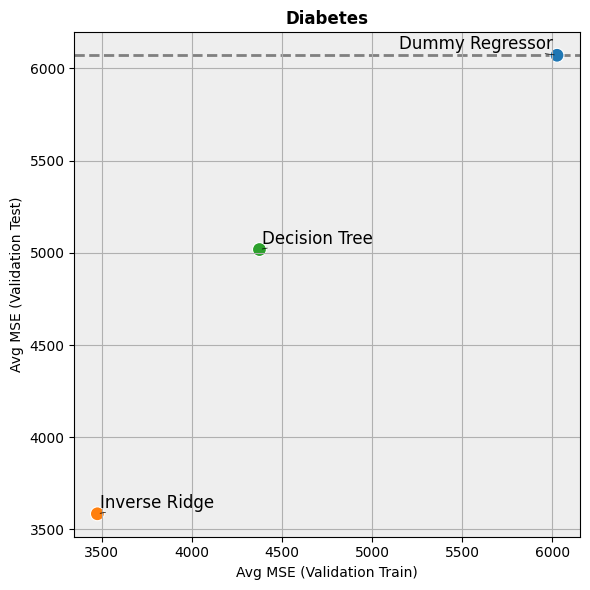

In [7]:
# Plot the results
hh.plot_batch_results(df_results, metric_name="MSE", title="Diabetes")

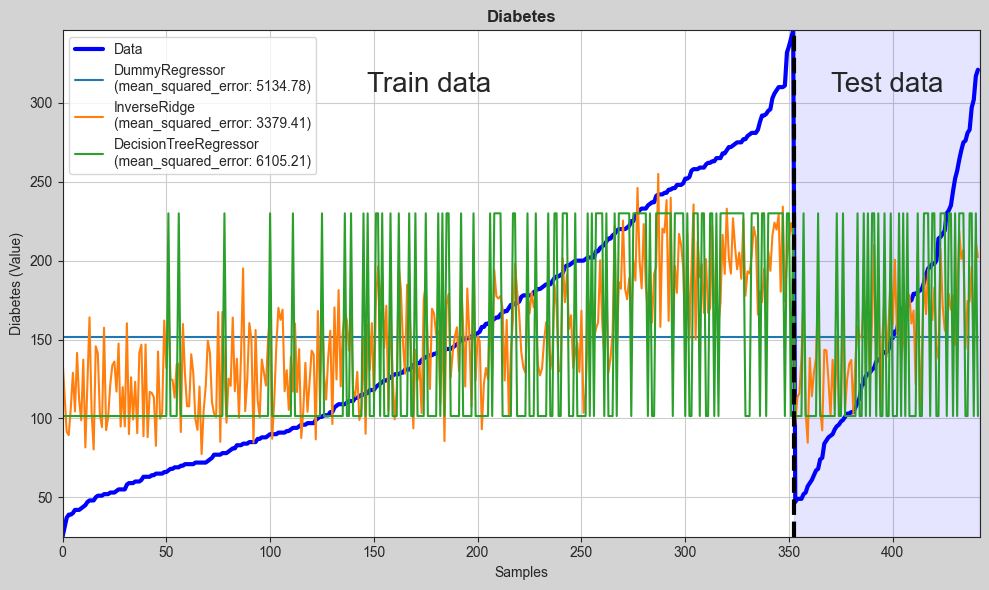

In [8]:
models = [i for _, i, _ in hh_models.trained_models]

hh.plot_regression_pred(X, y, models=models, metric=mean_squared_error,
                        title="Diabetes", y_label="Diabetes (Value)")